# DNN의 성능: 가우시안 퀀타일즈

In [6]:
# Package imports
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model
# Our own private imports
import imp
import joy
imp.reload(joy)

%matplotlib inline
np.random.seed(1)   # a good practice for reproducibility and debugging

# The following code is used for hiding the warnings and 
# make this notebook clearer.
#import warnings
#warnings.filterwarnings('ignore')

In [4]:
#%%writefile code/DeepNerualNet_BGD.py
#%load code/DeepNeuralNet_BGD.py
class DeepNeuralNet_BGD(object):
    """ implements a deep neural net. 
        Users may specify any number of layers.
        net_arch -- consists of a number of neurons in each layer 
    """
    def __init__(self, net_arch, activate = None, eta = 1.0, epochs = 100, random_seed = 1):
        
        if not isinstance(net_arch, list):
            sys.exit('Use a list to list number of neurons in each layer.')
        if len(net_arch) < 3:
            sys.exit('Specify the number of neurons more than two layers.')
                     
        self.eta = eta
        self.epochs = epochs
        self.net_arch = net_arch
        self.layers = len(net_arch)
        self.W = []
        self.random_seed = random_seed
        
        np.random.seed(self.random_seed)
        # Random initialization with range of weight values (-1,1)
        # A place holder None is used to indicated "unused place".
        self.W = [[None]]    ## the first W0 is not used.
        for layer in range(self.layers - 1):
            w = 2 * np.random.rand(self.net_arch[layer+1], 
                                   self.net_arch[layer]) - 1
            self.W.append(w)
        
        # initialize the activation function list with sigmoid() as default
        self.g = [lambda x: sigmoid(x) for _ in range(self.layers)]
        self.g_prime = [lambda x: sigmoid_d(x) for _ in range(self.layers)]
        
        # get the user-defined activation functions and their derivatives
        if activate is not None:
            if len(activate) % 2 != 0:
                sys.exit("List activation functions & its derivatives in pairwise")
            if len(activate) > (self.layers - 1) * 2:
                sys.exit("Too many activation functions & its derivatives encountered")
            for i, (g, g_prime) in enumerate(zip(activate[::2], activate[1::2])):
                self.g[i+1] = g
                self.g_prime[i+1] = g_prime
            
    def forpass(self, A0):     
        Z = [[None]] # Z0 is not used.
        A = []       # A0 = X0 is used. 
        A.append(A0)
        for i in range(1, len(self.W)):
            z = np.dot(self.W[i], A[i-1])
            Z.append(z)
            a = self.g[i](z)
            A.append(a)
        return Z, A
    
    def backprop(self, Z, A, Y):
        # initialize empty lists to save E and dZ
        # A place holder None is used to indicated "unused place".
        E  = [None for x in range(self.layers)]
        dZ = [None for x in range(self.layers)]
        
        # Get error at the output layer or the last layer
        ll = self.layers - 1
        error = Y - A[ll]
        E[ll] = error   
        dZ[ll] = error * self.g_prime[ll](Z[ll]) 
        
        # Begin from the back, from the next to last layer
        for i in range(self.layers-2, 0, -1):
            E[i]  = np.dot(self.W[i+1].T, E[i+1])
            dZ[i] = E[i] * self.g_prime[i](Z[i])
       
        # Adjust the weights 
        m = Y.shape[1]  # number of samples
        for i in range(ll, 0, -1):
            self.W[i] += self.eta * np.dot(dZ[i], A[i-1].T) / m
        return error
         
    def fit(self, X, y):
        self.cost_ = [] 
        self.m_samples = len(y)
        Y = joy.one_hot_encoding(y, self.net_arch[-1]) 
        
        for epoch in range(self.epochs): 
            #if epoch % 20== 0:
            #    print('Training epoch {}/{}'.format(epoch+1, self.epochs))

            A0 = np.array(X, ndmin=2).T   # A0 : inputs, minimum 2d array
            Y0 = np.array(Y, ndmin=2).T   # Y: targets

            Z, A = self.forpass(A0)          # forward pass
            cost = self.backprop(Z, A, Y0)   # back propagation
            self.cost_.append(np.sqrt(np.sum(cost * cost)))
        return self

    def predict(self, X):  # used in plot_decsion_regions()          
        Z, A2 = self.forpass(X)
        A2 = np.array(A2[len(A2)-1])
        return A2[-1] > 0.5
    
    def predict_(self, X): # used in evaluate() 
        A0 = np.array(X, ndmin=2).T         # A0: inputs
        Z, A = self.forpass(A0)             # forpass
        return A[-1]                                       
   
    def evaluate(self, Xtest, ytest):       # fully vectorized calculation
        m_samples = len(ytest)
        scores = 0        
        A3 = self.predict_(Xtest)
        yhat = np.argmax(A3, axis = 0)
        scores += np.sum(yhat == ytest)
        return scores/m_samples * 100

In [8]:

def tanh(x):
    return (1.0 - np.exp(-2*x))/(1.0 + np.exp(-2*x))

def tanh_d(x):
    return (1 + tanh(x))*(1 - tanh(x))

def sigmoid(x): 
    x = np.clip(x, -500, 500)  
    return 1/(1 + np.exp((-x)))

def sigmoid_d(x):
    return sigmoid(x) * (1 - sigmoid(x))

def relu(x):
    return np.maximum(x, 0)

def relu_d(x):
    x[x<=0] = 0
    x[x>0] = 1
    return x

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

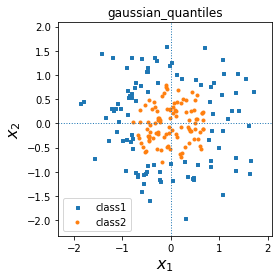

In [2]:
#은닉층의 층 개수가 1개일때와 3개일 때를 비교해보자!
import joy
x, y = joy.gaussian_quantiles(random_seed = 0)
joy.plot_xyw(x.T, y.squeeze(), title="gaussian_quantiles")

Accuracy 55.50000000000001%


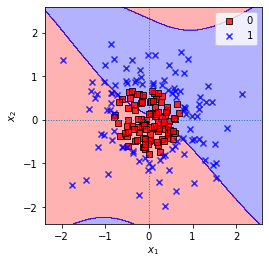

In [9]:
import joy
X, Y = joy.gaussian_quantiles(random_seed=1)
nn1 = DeepNeuralNet_BGD([2, 100, 2], eta=0.2, epochs=2000)
nn1.fit(X.T, Y.flatten())
accuracy = nn1.evaluate(X.T, Y.flatten())
print('Accuracy {}%'.format(accuracy))
joy.plot_decision_regions(X.T, Y.squeeze(), lambda z: nn1.predict(z.T))


Accuracy 99.5%


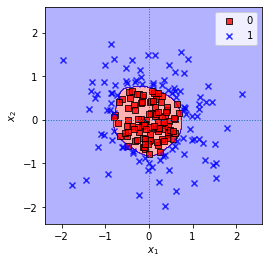

In [10]:
import joy
X, Y = joy.gaussian_quantiles(random_seed = 1)
nn2 = DeepNeuralNet_BGD([2, 60, 30, 10, 2], eta=0.2, epochs=2000)
nn2.fit(X.T, Y.flatten())
accuracy = nn2.evaluate(X.T, Y.flatten())
print("Accuracy {}%".format(accuracy))
joy.plot_decision_regions(X.T, Y.squeeze(), lambda z: nn2.predict(z.T))

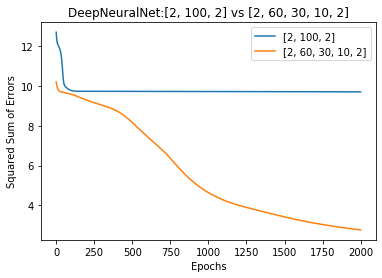

In [11]:
plt.plot(range(len(nn1.cost_)), nn1.cost_, label='{}'.format(nn1.net_arch))
plt.plot(range(len(nn2.cost_)), nn2.cost_, label='{}'.format(nn2.net_arch))
plt.title('DeepNeuralNet:{} vs {}'.format(nn1.net_arch, nn2.net_arch))
plt.xlabel('Epochs')
plt.ylabel('Squared Sum of Errors')
plt.legend(loc='best')
plt.show()

# DNN의 성능: 플라나 데이터

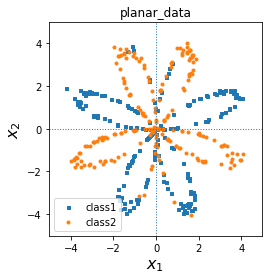

In [12]:
import joy
X, Y = joy.planar_data()
joy.plot_xyw(X.T, Y.squeeze(), title="planar_data")

In [13]:
import joy
X, y = joy.planar_data()
nn1 = DeepNeuralNet_BGD([2, 150, 2], eta=0.3, epochs=5000)
nn1.fit(X.T, y.flatten())
accuracy = nn1.evaluate(X.T, y.flatten())
print("Accuracy {}%".format(accuracy))

Accuracy 87.5%


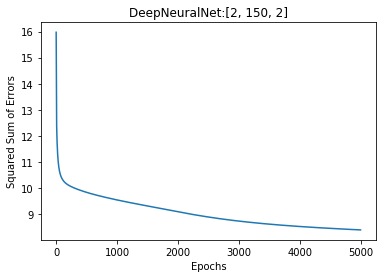

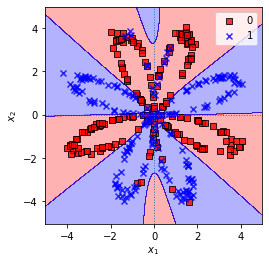

In [15]:
plt.plot(range(len(nn1.cost_)), nn1.cost_)
plt.xlabel('Epochs')
plt.ylabel('Squared Sum of Errors')
plt.title('DeepNeuralNet:{}'.format(nn1.net_arch))
plt.show()
joy.plot_decision_regions(X.T, y.squeeze(), lambda z: nn1.predict(z.T))

In [16]:
import joy
X, y = joy.planar_data()
nn2 = DeepNeuralNet_BGD([2, 100, 30, 20, 2], eta=0.2, epochs=5000)
nn2.fit(X.T, y.flatten())
accuracy = nn2.evaluate(X.T, y.flatten())
print("Accuracy {}%".format(accuracy))

Accuracy 90.75%


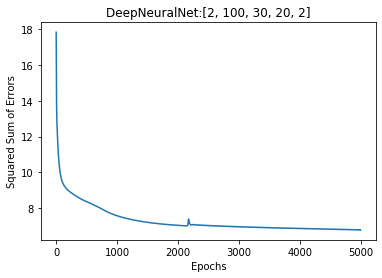

In [17]:
plt.plot(range(len(nn2.cost_)), nn2.cost_)
plt.xlabel('Epochs')
plt.ylabel('Squared Sum of Errors')
plt.title('DeepNeuralNet:{}'.format(nn2.net_arch))
plt.show()

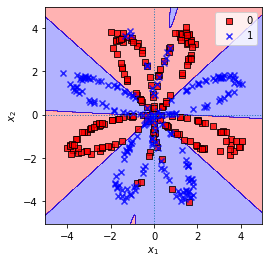

In [18]:
joy.plot_decision_regions(X.T, y.squeeze(), lambda z: nn2.predict(z.T))


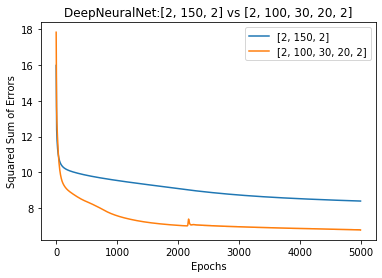

In [19]:
plt.plot(range(len(nn1.cost_)), nn1.cost_, label='{}'.format(nn1.net_arch))
plt.plot(range(len(nn2.cost_)), nn2.cost_, label='{}'.format(nn2.net_arch))
plt.title('DeepNeuralNet:{} vs {}'.format(nn1.net_arch, nn2.net_arch))
plt.xlabel('Epochs')
plt.ylabel('Squared Sum of Errors')
plt.legend(loc='best')
plt.show()

# 3.1 MNIST-Fashion DataSet: 데이터와 클래스 레이블


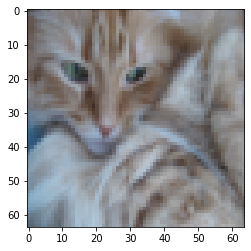

In [27]:
import joy
X, y, Xtest, ytest, classes = joy.load_cat_data()
plt.imshow(X[0])
plt.imshow(X[1])
plt.imshow(X[2])

In [31]:
print("Number of train examples:", X.shape[0])
print("Number of test  examples:", Xtest.shape[0])
print("One image size:({}, {}, {})".
      format(X.shape[1], X.shape[1], 3))
print("train X shape:", X.shape)
print("train y shape:", y.shape)
print("test  X shape:", Xtest.shape)
print("test  y shape:", ytest.shape)

Number of train examples: 209
Number of test  examples: 50
One image size:(64, 64, 3)
train X shape: (209, 64, 64, 3)
train y shape: (1, 209)
test  X shape: (50, 64, 64, 3)
test  y shape: (1, 50)


In [37]:

X_flatten = X.reshape(X.shape[0], -1)  # 12288 = 64*64*3 (특성을 하나로 shape)
Xtest_flatten = Xtest.reshape(Xtest.shape[0], -1)
X = X_flatten/255.
Xtest = Xtest_flatten/255.
print ("train X shape:", X.shape)
print ("test  X shape:", Xtest.shape)

train X shape: (209, 12288)
test  X shape: (50, 12288)


In [ ]:
import joy

for epoch in range(150, 180):
    dnn = DeepNeuralNet_BGD([12288, 100, 50, 2], eta = 0.3, epochs = epoch)  
    dnn.fit(X, y.flatten())   
    self = dnn.evaluate(X, y.flatten()) 
    test = dnn.evaluate(Xtest, ytest.flatten()) 
    print('Accuracy({}) self: {}%, test: {}%'.
          format(epoch, np.round(self, 2), np.round(test, 2)))

Accuracy(150) self: 65.55%, test: 34.0%
Accuracy(151) self: 65.55%, test: 34.0%
Accuracy(152) self: 65.55%, test: 34.0%
Accuracy(153) self: 65.55%, test: 34.0%
Accuracy(154) self: 65.55%, test: 34.0%
Accuracy(155) self: 65.55%, test: 34.0%
Accuracy(156) self: 65.55%, test: 34.0%
Accuracy(157) self: 65.55%, test: 34.0%
Accuracy(158) self: 65.55%, test: 34.0%
Accuracy(159) self: 65.55%, test: 34.0%
Accuracy(160) self: 65.55%, test: 34.0%
